# Registro Afín en 3D con DiPy

Cómputo de una tranformación afín para el registro de dos volúmenes 3D, maximizando su *Información Mutua*.

Importamos un par de funciones:

In [1]:
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)


Y cargamos dos volúmenes b0, uno *estático* y otro *en movimiento*:

In [2]:
fetch_stanford_hardi()
nib_stanford, gtab_stanford = read_stanford_hardi()
static = np.squeeze(nib_stanford.get_data())[..., 0]
static_grid2world = nib_stanford.affine

Dataset is already in place. If you want to fetch it again please first remove the folder /home/david/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/david/.dipy/stanford_hardi 


In [3]:
fetch_syn_data()
nib_syn_t1, nib_syn_b0 = read_syn_data()
moving = np.array(nib_syn_b0.get_data())
moving_grid2world = nib_syn_b0.affine

Creating new folder /home/david/.dipy/syn_test
Data size is approximately 12MB
Download Progress: [##################################] 100.00%  of 10.25 MBDownloading "b0.nii.gz" to /home/david/.dipy/syn_test
Download Progress: [##################################] 100.00%  of 1.34 MBFiles successfully downloaded to /home/david/.dipy/syn_test
Data size is approximately 12MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/david/.dipy/syn_test 


In [ ]:
Las imágenes, además de no estar alineadas, tienen distinto número de voxeles.

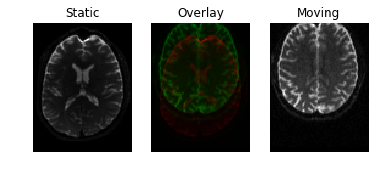

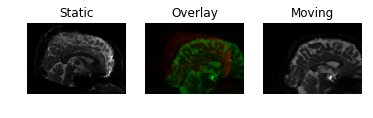

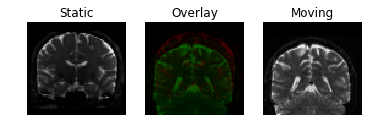

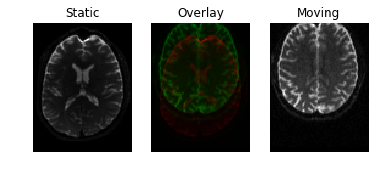

In [4]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       static.shape, static_grid2world,
                       moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)
regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")

Un registro rápido aunque tosco puede obtenerse si alineamos los centros de masa de las imágenes (sólo traslaciones):

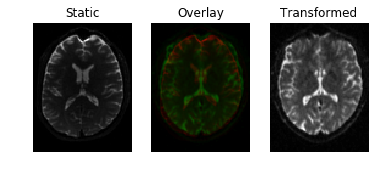

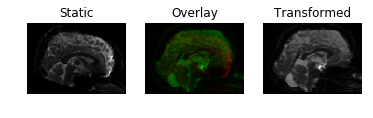

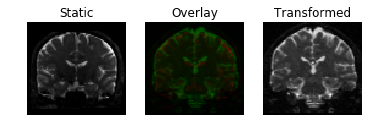

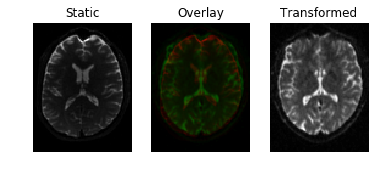

In [7]:
c_of_mass = transform_centers_of_mass(static, static_grid2world,
                                      moving, moving_grid2world)
transformed = c_of_mass.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_com_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_com_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_com_2.png")

Para mejorar el registro, creamos la métrica de similitud que usaremos:

In [10]:
nbins = 32 # bins used to discretize the joint and marginal probability distribution functions (PDF)
sampling_prop = None # Full sampling by if None instead of an integer
metric = MutualInformationMetric(nbins, sampling_prop)

level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1] # Parameters to avoid getting stuck at local optima and to accelerate convergence
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

Inicializamos este registro con una "buena" condición inicial; nuestro registro anterior:

In [11]:
transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,
                              static_grid2world, moving_grid2world,
                              starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


Que resulta:

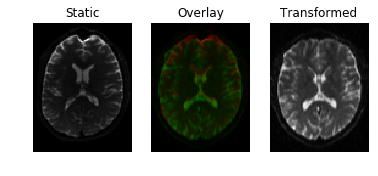

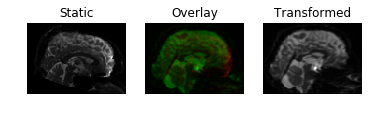

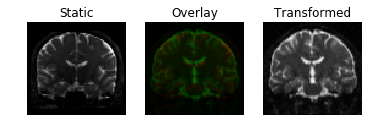

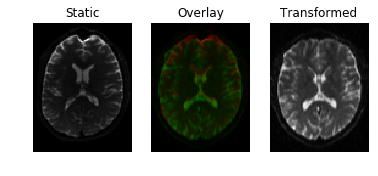

In [14]:
transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")

Ahora refinamos el registro aplicando una rotación (transforación estática): 

In [15]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


Que resulta:

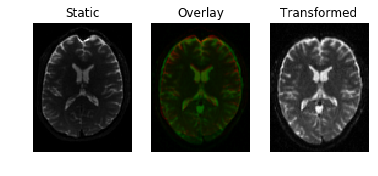

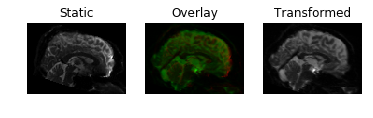

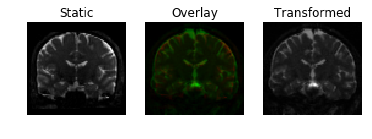

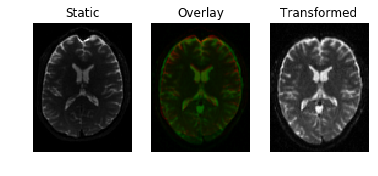

In [17]:
transformed = rigid.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_rigid_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_rigid_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_rigid_2.png")

Estando más cerca del óptimo, nuestra **cuarta transformación** afín (traslación, rotación, escalamiento, distorciones (paralelas)) será más precisa:

In [18]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


Y obtenemos:

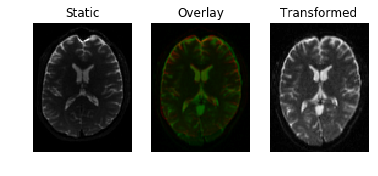

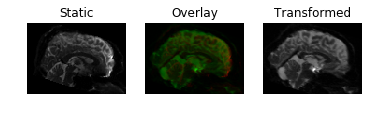

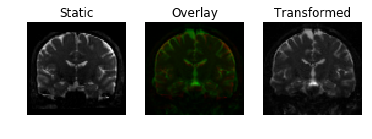

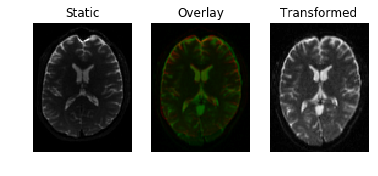

In [20]:
transformed = affine.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_affine_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_affine_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_affine_2.png")